# Imports

In [12]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


# 1D Poisson Equation



$$\frac{d^2 u}{dx^2} = f(x), \quad x \in (0, 1) \text{ with boundary conditions: $u(0)=0$ and $u(1)=1$}$$

The analytical solution: $u^*(x) = \sin(\pi x)$  
  
The source function: $f(x) = -\pi^2 \sin(\pi x)$

For simplicity of this problem, we denote the input as X and output as Y

## Define PDE & Simulate noisy data

In [13]:
# Analytical solution
u_star = lambda x: np.sin(math.pi * x)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return -(math.pi**2) * torch.sin(math.pi * x)

In [56]:
data_noise = 0.01

# Instantiate Poisson PDE problem
pde = Poisson1D(f_func=f_func, 
                bc_values=(torch.tensor([[0.0]]), torch.tensor([[0.0]])),
                domain=(0,1), true_solution=u_star)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)

# Collocation points in (0,1)
x_colloc_num = 50
x_collocation = torch.linspace(0.0, 1.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 1)].view(-1, 1)

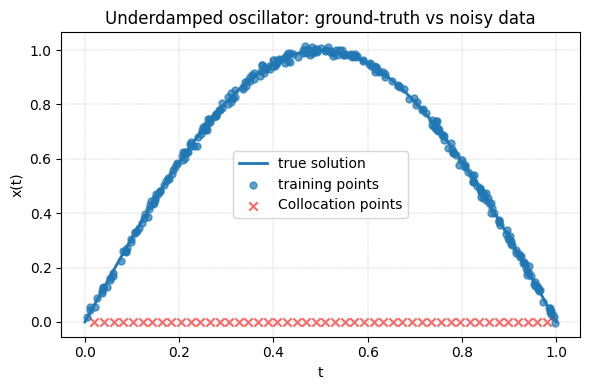

In [57]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 1,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=u_star,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

**Parameters for tuning prediction spread:**

- `rho`: define the Bayesian Layer parameters' spread
  
- `piror_std`: define the piror distribution's std
- `data_noise_guess`: define the guessed data noise in the loss function - negative log likelihood

In [ ]:
# from draft import VIBPINN

vi_poisson_model = VIBPINN(pde, 1, [16, 16], 1, mu_std=0.05, rho=-3, prior_std=100.0, init_data_noise=0.01, learn_data_noise=True)
loss_dict = vi_poisson_model.fit_vi_bpinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=10000, lr=3e-3,
                               λ_pde=1.0,λ_ic=0.0,λ_bc=1.0, λ_elbo=1.0)

ep     0 | L=3.24e+04 | elbo=3.01e+04 | pde=2.28e+03  ic=0.00e+00  bc=5.96e-04 | lr=3.00e-03 | learned noise_std=5.000e-02
ep     1 | L=4.09e+04 | elbo=3.87e+04 | pde=2.28e+03  ic=0.00e+00  bc=2.50e-03 | lr=3.00e-03 | learned noise_std=5.015e-02
ep   100 | L=6.44e+03 | elbo=4.18e+03 | pde=2.27e+03  ic=0.00e+00  bc=7.53e-01 | lr=3.00e-03 | learned noise_std=5.907e-02
ep   200 | L=5.62e+03 | elbo=3.35e+03 | pde=2.27e+03  ic=0.00e+00  bc=8.67e-01 | lr=3.00e-03 | learned noise_std=6.598e-02
ep   300 | L=4.85e+03 | elbo=2.58e+03 | pde=2.27e+03  ic=0.00e+00  bc=1.06e+00 | lr=3.00e-03 | learned noise_std=7.363e-02
ep   400 | L=4.29e+03 | elbo=2.03e+03 | pde=2.26e+03  ic=0.00e+00  bc=7.26e-01 | lr=3.00e-03 | learned noise_std=8.157e-02
ep   500 | L=4.00e+03 | elbo=1.76e+03 | pde=2.24e+03  ic=0.00e+00  bc=7.91e-01 | lr=3.00e-03 | learned noise_std=8.985e-02
ep   600 | L=3.90e+03 | elbo=1.69e+03 | pde=2.21e+03  ic=0.00e+00  bc=8.84e-01 | lr=3.00e-03 | learned noise_std=9.818e-02
ep   700 | L=3.3

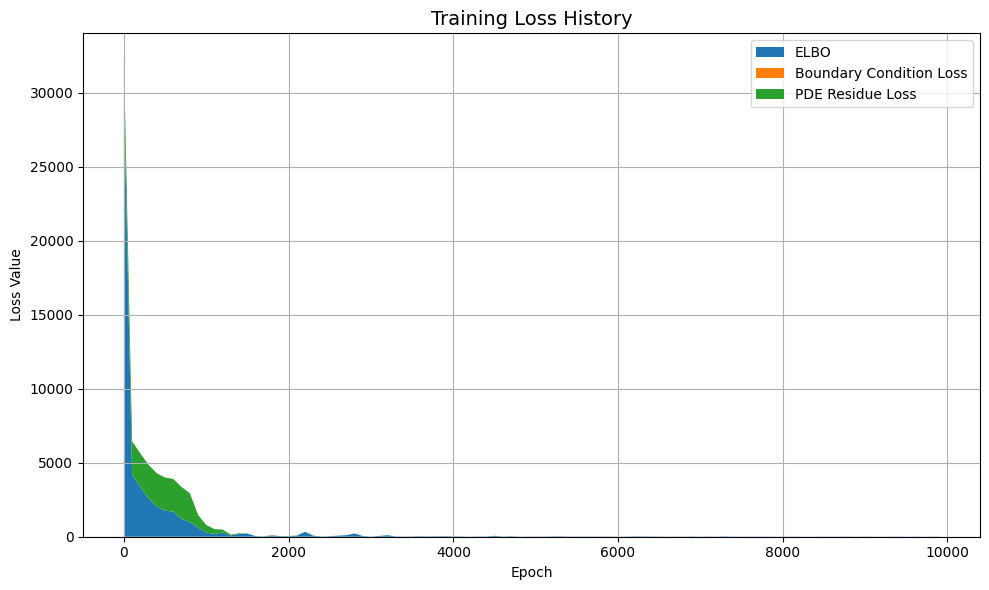

In [59]:
plot_training_history(loss_dict, plot_after=0, step=100)

In [60]:
x_grid = torch.linspace(0, 1, 100).view(-1, 1)
pred_set = vi_poisson_model.predict(x_grid, n_samples=1000, z_score=1.96)

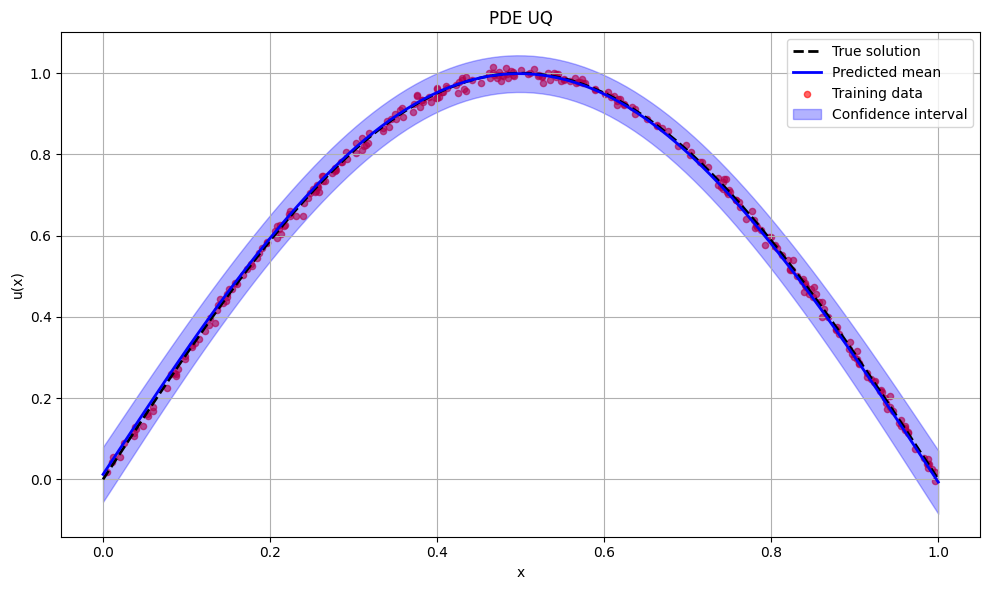

In [61]:
plot_predictions_1D(x_grid, pred_set, u_star, X=X_train, Y=Y_train)

## Sharpness & Coverage 

In [ ]:
test_uncertainties(vi_poisson_model, [])

NameError: name 'test_uncertainties' is not defined

### Sharpness

### Coverage